In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Distrito Federal - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_DF.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH,Distrito Federal - IDH Renda,Distrito Federal - Consumo de Cimento (t),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - PIB - Per Capita,Distrito Federal - PIB - Preços de Mercado,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.254227,4.896482e+06,8.293882,0.785137,12173.796800,0.835563,2.290151,887.301063,1472.275657,22.112973,15.990623,71.130346,2.506073,0.826971,0.871928,50.047,1.184017e+08,3.570616e+06,43.639430,1.092465e+08,156.625720,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.252655,4.934178e+06,8.287887,0.785313,12272.096031,0.835922,2.170793,887.625500,1467.038600,21.790128,15.663933,70.741484,2.494967,0.827063,0.871678,48.110,1.185511e+08,3.573184e+06,43.651300,1.093025e+08,157.678528,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.250972,4.971875e+06,8.281892,0.785489,12362.351216,0.836281,1.843974,887.995527,1443.186660,21.382001,14.859800,69.073150,2.482659,0.827155,0.871428,49.006,1.187006e+08,3.575752e+06,43.663170,1.093585e+08,159.190268,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.249179,5.009571e+06,8.275896,0.785664,12449.345859,0.836640,1.842883,888.753058,1484.414910,20.864040,13.463843,65.515153,2.541473,0.827247,0.871178,48.445,1.188500e+08,3.578320e+06,43.675041,1.094145e+08,160.688376,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.247070,5.047268e+06,8.269901,0.785840,12543.454480,0.836999,1.498497,889.051690,1487.564625,20.593129,12.206035,61.816227,2.562082,0.827340,0.870928,51.436,1.189994e+08,3.580889e+06,43.686911,1.094705e+08,162.847410,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,NaN,NaN,NaN,NaN,2.285520,888.063858,1554.000510,22.107259,11.557766,54.920321,2.663202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2002-9,NaN,NaN,NaN,NaN,NaN,NaN,2.459765,887.482239,1504.599147,22.342946,12.632697,58.260143,2.597288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,2002-10,NaN,NaN,NaN,NaN,NaN,NaN,2.404292,887.089138,1477.730987,22.495195,13.705746,61.921603,2.551755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,2002-11,NaN,NaN,NaN,NaN,NaN,NaN,2.375765,887.036669,1469.367571,22.206488,14.859807,66.774435,2.510615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


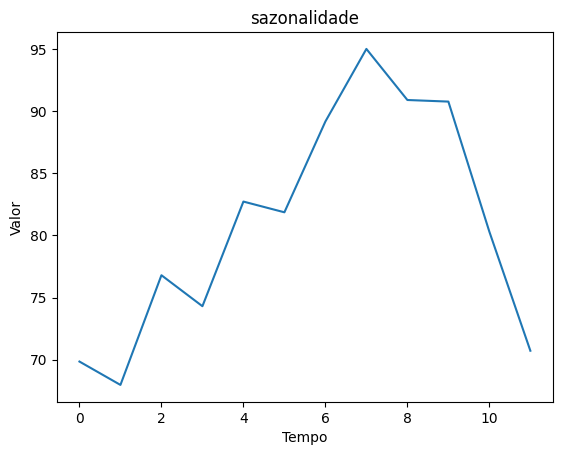

,sazonalidade
sazonalidade,
0,69.840417
1,67.957922
2,76.795043
3,74.298295
4,82.728116
5,81.864300
6,89.179786
7,95.025257
8,90.910616


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH,Distrito Federal - IDH Renda,Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - PIB - Per Capita,Distrito Federal - PIB - Preços de Mercado,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Distrito Federal - Consumo de Cimento (t)
0,2003-1,0.254227,4.896482e+06,8.293882,0.785137,12173.796800,0.835563,2.290151,887.301063,1472.275657,22.112973,15.990623,71.130346,2.506073,0.826971,0.871928,1.184017e+08,3.570616e+06,43.639430,1.092465e+08,156.625720,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,69.840417,50.047
1,2003-2,0.252655,4.934178e+06,8.287887,0.785313,12272.096031,0.835922,2.170793,887.625500,1467.038600,21.790128,15.663933,70.741484,2.494967,0.827063,0.871678,1.185511e+08,3.573184e+06,43.651300,1.093025e+08,157.678528,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,67.957922,48.110
2,2003-3,0.250972,4.971875e+06,8.281892,0.785489,12362.351216,0.836281,1.843974,887.995527,1443.186660,21.382001,14.859800,69.073150,2.482659,0.827155,0.871428,1.187006e+08,3.575752e+06,43.663170,1.093585e+08,159.190268,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,76.795043,49.006
3,2003-4,0.249179,5.009571e+06,8.275896,0.785664,12449.345859,0.836640,1.842883,888.753058,1484.414910,20.864040,13.463843,65.515153,2.541473,0.827247,0.871178,1.188500e+08,3.578320e+06,43.675041,1.094145e+08,160.688376,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,74.298295,48.445
4,2003-5,0.247070,5.047268e+06,8.269901,0.785840,12543.454480,0.836999,1.498497,889.051690,1487.564625,20.593129,12.206035,61.816227,2.562082,0.827340,0.870928,1.189994e+08,3.580889e+06,43.686911,1.094705e+08,162.847410,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,82.728116,51.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,NaN,NaN,NaN,NaN,2.285520,888.063858,1554.000510,22.107259,11.557766,54.920321,2.663202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.728116,NaN
269,2002-9,NaN,NaN,NaN,NaN,NaN,NaN,2.459765,887.482239,1504.599147,22.342946,12.632697,58.260143,2.597288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.864300,NaN
270,2002-10,NaN,NaN,NaN,NaN,NaN,NaN,2.404292,887.089138,1477.730987,22.495195,13.705746,61.921603,2.551755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.179786,NaN
271,2002-11,NaN,NaN,NaN,NaN,NaN,NaN,2.375765,887.036669,1469.367571,22.206488,14.859807,66.774435,2.510615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      62.294
1      55.247
2      65.908
3      67.387
4      68.730
        ...  
268       NaN
269       NaN
270       NaN
271       NaN
272       NaN
Name: Distrito Federal - Consumo de Cimento (t), Length: 273, dtype: float64

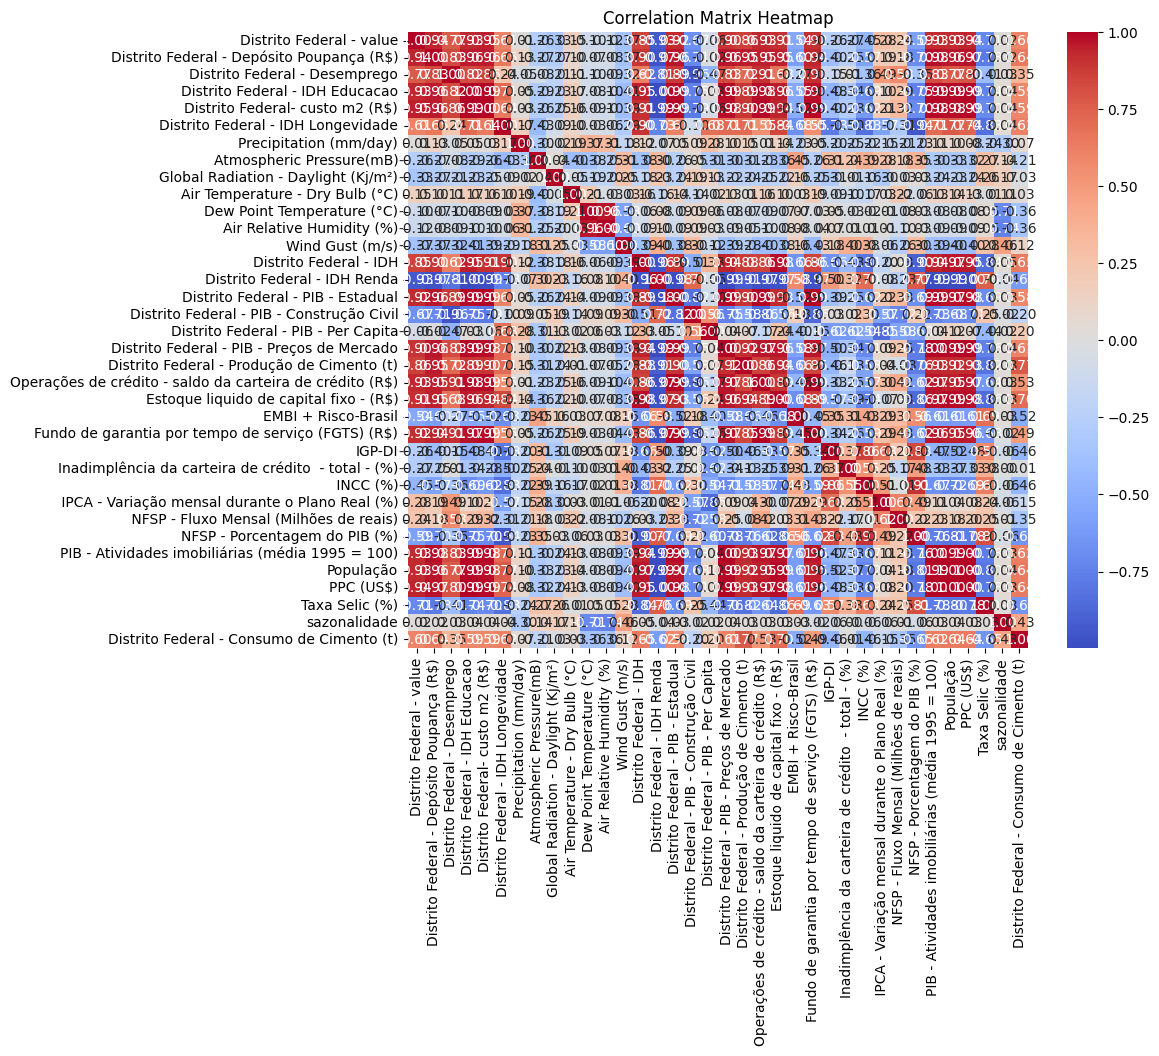

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Distrito Federal - value,2.318391e+03
1,Distrito Federal - Depósito Poupança (R$),9.014949e+03
2,Distrito Federal - Desemprego,3.308800e+03
3,Distrito Federal - IDH Educacao,2.333673e+06
4,Distrito Federal- custo m2 (R$),1.415182e+05
5,Distrito Federal - IDH Longevidade,1.731630e+04
6,Precipitation (mm/day),3.933114e+00
7,Atmospheric Pressure(mB),8.293349e+00
8,Global Radiation - Daylight (Kj/m²),3.811980e+00
9,Air Temperature - Dry Bulb (°C),4.662672e+01


In [39]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 5


,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,0.254227,4.896482e+06,8.293882,12173.796800,0.835563,2.290151,887.301063,1472.275657,22.112973,15.990623,71.130346,2.506073,1.184017e+08,3.570616e+06,156.625720,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,69.840417
1,0.252655,4.934178e+06,8.287887,12272.096031,0.835922,2.170793,887.625500,1467.038600,21.790128,15.663933,70.741484,2.494967,1.185511e+08,3.573184e+06,157.678528,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,67.957922
2,0.250972,4.971875e+06,8.281892,12362.351216,0.836281,1.843974,887.995527,1443.186660,21.382001,14.859800,69.073150,2.482659,1.187006e+08,3.575752e+06,159.190268,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,76.795043
3,0.249179,5.009571e+06,8.275896,12449.345859,0.836640,1.842883,888.753058,1484.414910,20.864040,13.463843,65.515153,2.541473,1.188500e+08,3.578320e+06,160.688376,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,74.298295
4,0.247070,5.047268e+06,8.269901,12543.454480,0.836999,1.498497,889.051690,1487.564625,20.593129,12.206035,61.816227,2.562082,1.189994e+08,3.580889e+06,162.847410,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,82.728116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.334841,1.026983e+07,12.178338,23809.706216,0.851476,1.332124,887.659555,1576.061861,22.576622,11.169376,54.269361,2.392892,1.412452e+08,3.433989e+06,261.777841,3.143856e+06,7.824899e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,1.969730e+08,390.589413,1.078474,95.025257
152,0.334852,1.021975e+07,12.190428,23906.884273,0.852107,1.447159,887.203690,1566.692397,23.122658,12.103300,56.019871,2.297928,1.413208e+08,3.433412e+06,260.098194,3.159665e+06,7.823710e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,1.970500e+08,391.798431,0.962516,90.910616
153,0.334672,1.016967e+07,12.202519,24004.583289,0.852739,1.719886,886.768648,1505.439888,22.982580,13.562263,61.709875,2.314441,1.413963e+08,3.432835e+06,258.524200,3.177292e+06,7.822521e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,1.971270e+08,393.032398,1.138989,90.782347
154,0.334156,1.011958e+07,12.214609,24106.069162,0.853370,2.056456,886.664027,1514.365234,22.796211,14.799960,65.966642,2.254536,1.414718e+08,3.432259e+06,256.649867,3.192250e+06,7.821333e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,1.972040e+08,394.326420,1.038436,80.300832


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,-1.492601,-0.610800,-1.525287,-2.881822,0.382754,-0.085626,-0.306870,1.296582,1.134739,0.721852,0.416907,-1.563327,0.100620,-1.834304,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617
1,-1.475655,-0.614446,-1.498127,-2.801579,0.005805,0.090147,-0.310832,0.732055,0.956397,0.661889,0.356016,-1.542545,0.142290,-1.812850,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013
2,-1.458709,-0.618093,-1.473190,-2.721337,-1.026331,0.290619,-0.328876,0.018401,0.517414,0.404628,0.288529,-1.521762,0.183961,-1.782044,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457
3,-1.441763,-0.621740,-1.449154,-2.641094,-1.029776,0.701033,-0.297686,-0.887307,-0.244650,-0.144024,0.611004,-1.500979,0.225631,-1.751515,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128
4,-1.424818,-0.625386,-1.423152,-2.560852,-2.117392,0.862825,-0.295303,-1.361022,-0.931297,-0.714406,0.724002,-1.480197,0.267301,-1.707518,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.922887,1.751927,1.689680,0.674150,-2.642821,0.108597,-0.228354,2.107321,-1.497218,-1.878150,-0.203655,1.614194,-2.116219,0.308489,1.823582,0.951535,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.382734,1.398025,0.209123
152,0.900374,1.759281,1.716530,0.815251,-2.279526,-0.138381,-0.235442,3.062121,-0.987381,-1.608218,-0.724340,1.624702,-2.125575,0.274261,1.841017,0.944143,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.395760,1.415152,-0.182135
153,0.877860,1.766636,1.743524,0.956353,-1.418217,-0.374077,-0.281780,2.817181,-0.190922,-0.730806,-0.633800,1.635210,-2.134931,0.242186,1.860456,0.936751,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.408786,1.432633,0.413308
154,0.855347,1.773990,1.771564,1.097455,-0.355286,-0.430758,-0.275028,2.491296,0.484747,-0.074403,-0.962254,1.645718,-2.144287,0.203991,1.876950,0.929358,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.421813,1.450965,0.074029


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,-1.492601,-0.610800,-1.525287,-2.881822,0.382754,-0.085626,-0.306870,1.296582,1.134739,0.721852,0.416907,-1.563327,0.100620,-1.834304,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617
1,-1.475655,-0.614446,-1.498127,-2.801579,0.005805,0.090147,-0.310832,0.732055,0.956397,0.661889,0.356016,-1.542545,0.142290,-1.812850,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013
2,-1.458709,-0.618093,-1.473190,-2.721337,-1.026331,0.290619,-0.328876,0.018401,0.517414,0.404628,0.288529,-1.521762,0.183961,-1.782044,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457
3,-1.441763,-0.621740,-1.449154,-2.641094,-1.029776,0.701033,-0.297686,-0.887307,-0.244650,-0.144024,0.611004,-1.500979,0.225631,-1.751515,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128
4,-1.424818,-0.625386,-1.423152,-2.560852,-2.117392,0.862825,-0.295303,-1.361022,-0.931297,-0.714406,0.724002,-1.480197,0.267301,-1.707518,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.275569,1.625959,1.388530,-0.113418,0.628146,0.198667,-0.229468,0.762429,-1.590782,-1.730313,-0.701235,1.456763,-1.789276,0.938844,1.517172,1.018624,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.222749,1.245801,-0.282621
140,1.236551,1.640857,1.411185,-0.153447,0.570094,-0.106956,-0.267023,1.091575,-0.887366,-1.070542,-0.419641,1.473538,-1.841566,0.887161,1.549848,1.015555,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.236509,1.254608,-0.612121
141,1.197533,1.655755,1.433752,-0.193476,1.740620,-0.250286,-0.266745,1.225622,-0.391742,-0.621073,-0.704071,1.490313,-1.893856,0.834652,1.588878,1.012487,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.250269,1.263636,-0.137902
142,1.158515,1.670653,1.456256,-0.233504,0.920319,-0.392590,-0.288140,1.018729,0.254006,0.049395,-0.783229,1.507088,-1.946146,0.781177,1.625721,1.009418,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.264029,1.272935,-0.332143


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      62.294000
1      55.247000
2      65.908000
3      67.387000
4      68.730000
         ...    
139    59.501277
140    56.430184
141    57.163926
142    51.007812
143    48.477000
Name: Distrito Federal - Consumo de Cimento (t), Length: 144, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 28)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
108,0.661236,0.891194,0.732890,0.768235,0.380401,-0.791974,-0.352497,-0.318290,0.894253,1.064454,-0.612808,0.719175,-0.219174,1.251932,0.595959,0.890825,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.754385,0.812014,-1.082183
109,0.737774,0.920520,0.749266,0.747902,0.457683,-0.586708,-0.336661,-0.466630,0.808896,0.972825,-0.632454,0.746872,-0.271286,1.315688,0.621380,0.900214,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.770574,0.831569,-1.036767
110,0.814311,0.949845,0.765740,0.727568,0.086321,-0.301281,-0.345172,-0.700140,0.647115,0.824587,-0.771850,0.774569,-0.323397,1.376712,0.652999,0.909602,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.786763,0.850791,-0.752482
111,0.890848,0.979171,0.781911,0.707234,-0.921354,-0.004368,-0.336925,-1.215157,0.131599,0.401261,-0.545581,0.802266,-0.375508,1.411696,0.685630,0.918990,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.802953,0.868783,-1.088413
112,0.967386,1.008496,0.798249,0.686900,-2.146751,0.419952,-0.315192,-1.934853,-0.642665,-0.199824,0.576480,0.829963,-0.427619,1.445016,0.717515,0.928378,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.819142,0.886720,-1.508135
113,1.043923,1.037821,0.815107,0.666567,-2.342820,0.586877,-0.261584,-1.131292,-1.304275,-1.068240,0.914249,0.857660,-0.479730,1.467379,0.747579,0.937766,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.835331,0.905151,-1.474280
114,1.120460,1.067147,0.833584,0.646233,-0.802451,0.465462,-0.220968,-0.314223,-1.757214,-1.709112,1.364208,0.885357,-0.531841,1.481531,0.775262,0.947155,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.851520,0.923702,-1.463452
115,1.196998,1.096472,0.851827,0.625899,-0.181246,0.162328,-0.241170,0.199800,-1.367125,-1.404098,1.513065,0.913054,-0.583952,1.486641,0.805205,0.956543,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.867709,0.942382,-1.236037
116,1.273535,1.125798,0.870059,0.605565,1.055163,-0.287898,-0.248981,1.179901,-0.793218,-1.066941,0.533589,0.940752,-0.636063,1.475466,0.836796,0.965931,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.883899,0.960385,-0.935721
117,1.350072,1.155123,0.888817,0.585232,1.679500,-0.638463,-0.304689,0.929852,-0.046020,-0.224064,0.190969,0.968449,-0.688174,1.470313,0.876422,0.975319,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.900088,0.977769,-1.241995


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 28)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(72, activation='tanh', 
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1186933730, 521542352, 1823715020, 2055056062, 262596172, 2621304311, 1023540072, 1408151443, 2746551023, 1402625948]


Step: 0 ___________________________________________
val_loss: 52.176361083984375
winner_seed: 1186933730


Step: 1 ___________________________________________
val_loss: 9.700342178344727
winner_seed: 521542352


Step: 2 ___________________________________________
val_loss: 4.600559234619141
winner_seed: 1823715020


Step: 3 ___________________________________________
val_loss: 33.07975769042969


Step: 4 ___________________________________________
val_loss: 10.826972961425781


Step: 5 ___________________________________________
val_loss: 8.899322509765625


Step: 6 ___________________________________________
val_loss: 14.126489639282227


Step: 7 ___________________________________________
val_loss: 7.568423271179199


Step: 8 ___________________________________________
val_loss: 5.210925102233887


Step: 9 ___________________________________________
val_loss: 3.833

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 3105829098

Epoch 1/10000
4/4 [==============================] - 2s 127ms/step - loss: 6985.1011 - val_loss: 807.8803
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 372.7563 - val_loss: 767.6563
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 538.2543 - val_loss: 1225.8680
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 346.9830 - val_loss: 1144.9768
Epoch 5/10000
4/4 [==============================] - 0s 11ms/step - loss: 343.5328 - val_loss: 1302.6776
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 340.7291 - val_loss: 896.1653
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 324.2509 - val_loss: 928.6422
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 311.0395 - val_loss: 689.0487
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 304.1169 - val_loss: 1511.1514
Epoch 10/10000
4/4 [==============================] - 0s 1

Epoch 80/10000
4/4 [==============================] - 0s 12ms/step - loss: 46.9052 - val_loss: 12.5639
Epoch 81/10000
4/4 [==============================] - 0s 10ms/step - loss: 52.0382 - val_loss: 11.3527
Epoch 82/10000
4/4 [==============================] - 0s 10ms/step - loss: 39.9345 - val_loss: 58.9263
Epoch 83/10000
4/4 [==============================] - 0s 11ms/step - loss: 50.3691 - val_loss: 18.5839
Epoch 84/10000
4/4 [==============================] - 0s 10ms/step - loss: 39.3784 - val_loss: 24.2996
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 45.5122 - val_loss: 25.9233
Epoch 86/10000
4/4 [==============================] - 0s 10ms/step - loss: 40.6419 - val_loss: 13.0553
Epoch 87/10000
4/4 [==============================] - 0s 10ms/step - loss: 54.1515 - val_loss: 64.0682
Epoch 88/10000
4/4 [==============================] - 0s 10ms/step - loss: 49.9802 - val_loss: 12.0724
Epoch 89/10000
4/4 [==============================] - 0s 9ms/step - loss:

4/4 [==============================] - 0s 9ms/step - loss: 27.8721 - val_loss: 162.4547
Epoch 160/10000
4/4 [==============================] - 0s 10ms/step - loss: 34.2547 - val_loss: 21.4298
Epoch 161/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.1197 - val_loss: 14.5650
Epoch 162/10000
4/4 [==============================] - 0s 10ms/step - loss: 32.3910 - val_loss: 13.9430
Epoch 163/10000
4/4 [==============================] - 0s 10ms/step - loss: 33.1451 - val_loss: 14.6506
Epoch 164/10000
4/4 [==============================] - 0s 10ms/step - loss: 34.5372 - val_loss: 20.5616
Epoch 165/10000
4/4 [==============================] - 0s 10ms/step - loss: 28.4244 - val_loss: 128.4563
Epoch 166/10000
4/4 [==============================] - 0s 10ms/step - loss: 37.1699 - val_loss: 162.5269
Epoch 167/10000
4/4 [==============================] - 0s 10ms/step - loss: 36.1118 - val_loss: 21.3214
Epoch 168/10000
4/4 [==============================] - 0s 10ms/step - loss: 35

Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 20.4323 - val_loss: 22.2832
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 27.3213 - val_loss: 17.0824
Epoch 240/10000
4/4 [==============================] - 0s 10ms/step - loss: 23.0619 - val_loss: 67.9133
Epoch 241/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.7470 - val_loss: 20.0491
Epoch 242/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.0445 - val_loss: 134.3573
Epoch 243/10000
4/4 [==============================] - 0s 11ms/step - loss: 26.6903 - val_loss: 53.9992
Epoch 244/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.7244 - val_loss: 76.0219
Epoch 245/10000
4/4 [==============================] - 0s 9ms/step - loss: 23.9784 - val_loss: 34.7286
Epoch 246/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.2261 - val_loss: 196.1922
Epoch 247/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 10ms/step - loss: 18.6315 - val_loss: 93.3899
Epoch 317/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.2068 - val_loss: 56.4468
Epoch 318/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.9810 - val_loss: 47.5772
Epoch 319/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.5137 - val_loss: 69.0175
Epoch 320/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.5385 - val_loss: 63.0622
Epoch 321/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.6070 - val_loss: 103.1094
Epoch 322/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.3295 - val_loss: 70.7103
Epoch 323/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.4868 - val_loss: 116.0561
Epoch 324/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.7969 - val_loss: 53.9740
Epoch 325/10000
4/4 [==============================] - 0s 10ms/step - loss: 18

Epoch 395/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.4403 - val_loss: 37.1683
Epoch 396/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.8016 - val_loss: 57.0968
Epoch 397/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.7819 - val_loss: 84.3386
Epoch 398/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.0588 - val_loss: 52.0240
Epoch 399/10000
4/4 [==============================] - 0s 9ms/step - loss: 19.5469 - val_loss: 47.9715
Epoch 400/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.4514 - val_loss: 45.1621
Epoch 401/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.6425 - val_loss: 46.8455
Epoch 402/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.3189 - val_loss: 67.3512
Epoch 403/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.5671 - val_loss: 31.5524
Epoch 404/10000
4/4 [==============================] - 0s 9ms/step

Epoch 474/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.7415 - val_loss: 30.9864
Epoch 475/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.5646 - val_loss: 38.8897
Epoch 476/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.0321 - val_loss: 64.9633
Epoch 477/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.6371 - val_loss: 75.6025
Epoch 478/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.2406 - val_loss: 35.8276
Epoch 479/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.8372 - val_loss: 69.7224
Epoch 480/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.6113 - val_loss: 64.8222
Epoch 481/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.3540 - val_loss: 57.2679
Epoch 482/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.8254 - val_loss: 33.7155
Epoch 483/10000
4/4 [==============================] - 0s 11ms/st

Epoch 553/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.8731 - val_loss: 32.0141
Epoch 554/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.8854 - val_loss: 67.5296
Epoch 555/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.6407 - val_loss: 34.2963
Epoch 556/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.9292 - val_loss: 22.4272
Epoch 557/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.4723 - val_loss: 38.4737
Epoch 558/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.8906 - val_loss: 62.7641
Epoch 559/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.4585 - val_loss: 40.1632
Epoch 560/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.5167 - val_loss: 30.5882
Epoch 561/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.6650 - val_loss: 56.4843
Epoch 562/10000
4/4 [==============================] - 0s 11ms/st

Epoch 632/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.5187 - val_loss: 26.9215
Epoch 633/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.9769 - val_loss: 59.5688
Epoch 634/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.7024 - val_loss: 33.4575
Epoch 635/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.7919 - val_loss: 35.5012
Epoch 636/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.4470 - val_loss: 30.7432
Epoch 637/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.3978 - val_loss: 43.1079
Epoch 638/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.8987 - val_loss: 39.2516
Epoch 639/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.2940 - val_loss: 34.9606
Epoch 640/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.2217 - val_loss: 45.9472
Epoch 641/10000
4/4 [==============================] - 0s 12ms/st

4/4 [==============================] - 0s 10ms/step - loss: 11.1905 - val_loss: 54.3648
Epoch 712/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.1334 - val_loss: 42.9879
Epoch 713/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.4775 - val_loss: 41.5050
Epoch 714/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.2116 - val_loss: 65.2350
Epoch 715/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.2837 - val_loss: 48.3712
Epoch 716/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.7211 - val_loss: 46.2972
Epoch 717/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.1759 - val_loss: 44.3864
Epoch 718/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.0868 - val_loss: 20.4050
Epoch 719/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.3021 - val_loss: 88.7825
Epoch 720/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.7025 - 

4/4 [==============================] - 0s 11ms/step - loss: 11.5172 - val_loss: 32.6236
Epoch 791/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.0950 - val_loss: 37.7441
Epoch 792/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.9739 - val_loss: 57.0231
Epoch 793/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.1592 - val_loss: 39.4931
Epoch 794/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.5270 - val_loss: 53.9691
Epoch 795/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.6340 - val_loss: 59.1379
Epoch 796/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.7463 - val_loss: 45.2759
Epoch 797/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.1654 - val_loss: 54.9501
Epoch 798/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.1077 - val_loss: 40.0101
Epoch 799/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.6

4/4 [==============================] - 0s 11ms/step - loss: 11.2703 - val_loss: 43.3815
Epoch 870/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.2462 - val_loss: 49.4861
Epoch 871/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.0606 - val_loss: 111.1679
Epoch 872/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.4882 - val_loss: 28.6975
Epoch 873/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.2350 - val_loss: 58.4479
Epoch 874/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.1522 - val_loss: 34.9223
Epoch 875/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.8701 - val_loss: 68.3900
Epoch 876/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.4176 - val_loss: 63.7321
Epoch 877/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.3388 - val_loss: 66.6782
Epoch 878/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.9

4/4 [==============================] - 0s 9ms/step - loss: 9.8865 - val_loss: 56.7369
Epoch 949/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.6214 - val_loss: 32.5741
Epoch 950/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.3798 - val_loss: 53.3385
Epoch 951/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.4457 - val_loss: 41.0281
Epoch 952/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.5670 - val_loss: 42.3217
Epoch 953/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.4606 - val_loss: 84.5613
Epoch 954/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.6450 - val_loss: 51.1542
Epoch 955/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.5315 - val_loss: 43.3178
Epoch 956/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.6478 - val_loss: 62.7894
Epoch 957/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.9456 - val_l

4/4 [==============================] - 0s 12ms/step - loss: 10.7044 - val_loss: 64.5393
Epoch 1028/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.7717 - val_loss: 47.4835
Epoch 1029/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.3223 - val_loss: 48.0948
Epoch 1030/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.9501 - val_loss: 59.0011
Epoch 1031/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.2198 - val_loss: 63.6284
Epoch 1032/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.6321 - val_loss: 46.4328
Epoch 1033/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.5464 - val_loss: 185.4737
Epoch 1034/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.7057 - val_loss: 54.5552
Epoch 1035/10000
4/4 [==============================] - 0s 13ms/step - loss: 36.8040 - val_loss: 8.5715
Epoch 1036/10000
4/4 [==============================] - 0s 13ms/step - loss:

4/4 [==============================] - 0s 11ms/step - loss: 10.4676 - val_loss: 42.9874
Epoch 1106/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.8423 - val_loss: 43.4213
Epoch 1107/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.9847 - val_loss: 44.8935
Epoch 1108/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.2523 - val_loss: 31.9074
Epoch 1109/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.1484 - val_loss: 53.3040
Epoch 1110/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.2111 - val_loss: 90.0512
Epoch 1111/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.9936 - val_loss: 12.5144
Epoch 1112/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.1450 - val_loss: 63.2497
Epoch 1113/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.9276 - val_loss: 329.6835
Epoch 1114/10000
4/4 [==============================] - 0s 10ms/step - loss:

4/4 [==============================] - 0s 13ms/step - loss: 7.5571 - val_loss: 53.1752
Epoch 1184/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.6785 - val_loss: 34.4656
Epoch 1185/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.0469 - val_loss: 38.0566
Epoch 1186/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.7666 - val_loss: 22.8707
Epoch 1187/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.4326 - val_loss: 33.5306
Epoch 1188/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.1387 - val_loss: 45.5715
Epoch 1189/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.2669 - val_loss: 31.6020
Epoch 1190/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.2263 - val_loss: 51.5796
Epoch 1191/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.8691 - val_loss: 30.1525
Epoch 1192/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.96

Epoch 1262/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.9055 - val_loss: 15.5976
Epoch 1263/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.6710 - val_loss: 40.8981
Epoch 1264/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.8874 - val_loss: 28.4177
Epoch 1265/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.5968 - val_loss: 20.1445
Epoch 1266/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.6562 - val_loss: 17.9224
Epoch 1267/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.1828 - val_loss: 21.8963
Epoch 1268/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.0852 - val_loss: 26.9406
Epoch 1269/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.2175 - val_loss: 27.1512
Epoch 1270/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.5321 - val_loss: 18.9433
Epoch 1271/10000
4/4 [==============================] - 0s 9ms/step

Epoch 1341/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.9908 - val_loss: 10.1237
Epoch 1342/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.5432 - val_loss: 21.4554
Epoch 1343/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.4569 - val_loss: 16.7479
Epoch 1344/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.9656 - val_loss: 24.4542
Epoch 1345/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.2891 - val_loss: 28.5906
Epoch 1346/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.2013 - val_loss: 22.9008
Epoch 1347/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.3154 - val_loss: 24.5344
Epoch 1348/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.4894 - val_loss: 27.0280
Epoch 1349/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.7651 - val_loss: 22.0440
Epoch 1350/10000
4/4 [==============================] - 0s 10ms

Epoch 1420/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.4598 - val_loss: 17.7393
Epoch 1421/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.7118 - val_loss: 63.8557
Epoch 1422/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.2637 - val_loss: 59.5247
Epoch 1423/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.7663 - val_loss: 40.7086
Epoch 1424/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.0281 - val_loss: 20.7904
Epoch 1425/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.1569 - val_loss: 17.7148
Epoch 1426/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.7536 - val_loss: 25.0006
Epoch 1427/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.4915 - val_loss: 26.9699
Epoch 1428/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.1271 - val_loss: 27.9329
Epoch 1429/10000
4/4 [==============================] - 0s 10ms

Epoch 1499/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.7473 - val_loss: 16.4326
Epoch 1500/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.1544 - val_loss: 18.7274
Epoch 1501/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.8976 - val_loss: 23.6095
Epoch 1502/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.4961 - val_loss: 23.8061
Epoch 1503/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.1859 - val_loss: 13.8458
Epoch 1504/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.3962 - val_loss: 15.9412
Epoch 1505/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.5386 - val_loss: 28.5684
Epoch 1506/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.9428 - val_loss: 29.2329
Epoch 1507/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.6315 - val_loss: 21.0545
Epoch 1508/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 12ms/step - loss: 6.6984 - val_loss: 9.4765
Epoch 1579/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.3213 - val_loss: 11.2871
Epoch 1580/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.9280 - val_loss: 7.8603
Epoch 1581/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.5558 - val_loss: 7.9685
Epoch 1582/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.7598 - val_loss: 15.6735
Epoch 1583/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.6061 - val_loss: 8.2225
Epoch 1584/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.4116 - val_loss: 8.4297
Epoch 1585/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.4173 - val_loss: 11.6811
Epoch 1586/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.8244 - val_loss: 13.8688
Epoch 1587/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.2082 - 

4/4 [==============================] - 0s 10ms/step - loss: 6.0067 - val_loss: 10.0300
Epoch 1658/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.7012 - val_loss: 8.3948
Epoch 1659/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.1354 - val_loss: 6.2526
Epoch 1660/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.2573 - val_loss: 6.3468
Epoch 1661/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.8458 - val_loss: 7.9299
Epoch 1662/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.9920 - val_loss: 7.3853
Epoch 1663/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.0971 - val_loss: 14.7061
Epoch 1664/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.3346 - val_loss: 9.2277
Epoch 1665/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.5350 - val_loss: 11.5897
Epoch 1666/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.0513 - v

4/4 [==============================] - 0s 10ms/step - loss: 6.3599 - val_loss: 12.7272
Epoch 1737/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.5826 - val_loss: 5.8272
Epoch 1738/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.6076 - val_loss: 5.8180
Epoch 1739/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.2231 - val_loss: 8.3980
Epoch 1740/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.1933 - val_loss: 7.5673
Epoch 1741/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.9753 - val_loss: 7.2410
Epoch 1742/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.2255 - val_loss: 6.5920
Epoch 1743/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.8598 - val_loss: 5.9355
Epoch 1744/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.1594 - val_loss: 5.8572
Epoch 1745/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.8578 - val

Epoch 1816/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.5387 - val_loss: 11.3312
Epoch 1817/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.7572 - val_loss: 5.7296
Epoch 1818/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.4691 - val_loss: 5.5265
Epoch 1819/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.3932 - val_loss: 5.7145
Epoch 1820/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.8910 - val_loss: 9.4616
Epoch 1821/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.6387 - val_loss: 5.4786
Epoch 1822/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.3437 - val_loss: 5.5041
Epoch 1823/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.1542 - val_loss: 5.6345
Epoch 1824/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.0533 - val_loss: 6.2023
Epoch 1825/10000
4/4 [==============================] - 0s 9ms/step - loss: 

Epoch 1896/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2597 - val_loss: 6.3175
Epoch 1897/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.4973 - val_loss: 6.0561
Epoch 1898/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.1159 - val_loss: 5.6821
Epoch 1899/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.5759 - val_loss: 5.3759
Epoch 1900/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.8041 - val_loss: 6.3459
Epoch 1901/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.4001 - val_loss: 8.8718
Epoch 1902/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.1799 - val_loss: 6.6639
Epoch 1903/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.3005 - val_loss: 5.7402
Epoch 1904/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.5955 - val_loss: 6.3918
Epoch 1905/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 11ms/step - loss: 5.3538 - val_loss: 6.2358
Epoch 1976/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.1995 - val_loss: 6.9246
Epoch 1977/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.2706 - val_loss: 5.4497
Epoch 1978/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.9315 - val_loss: 6.5849
Epoch 1979/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.0112 - val_loss: 8.2599
Epoch 1980/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.8729 - val_loss: 5.4739
Epoch 1981/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.6186 - val_loss: 14.5909
Epoch 1982/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.7197 - val_loss: 11.1025
Epoch 1983/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.8884 - val_loss: 5.9688
Epoch 1984/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2710 - va

4/4 [==============================] - 0s 10ms/step - loss: 5.4322 - val_loss: 5.2501
Epoch 2055/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.6519 - val_loss: 13.3551
Epoch 2056/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.7516 - val_loss: 4.9319
Epoch 2057/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2106 - val_loss: 5.7969
Epoch 2058/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.6979 - val_loss: 6.1226
Epoch 2059/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2690 - val_loss: 6.4157
Epoch 2060/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3723 - val_loss: 4.8674
Epoch 2061/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.9733 - val_loss: 5.5707
Epoch 2062/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.3462 - val_loss: 7.1195
Epoch 2063/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.6744 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 5.5313 - val_loss: 7.8677
Epoch 2135/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.6041 - val_loss: 9.3234
Epoch 2136/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1812 - val_loss: 6.9571
Epoch 2137/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.5490 - val_loss: 5.0625
Epoch 2138/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2163 - val_loss: 5.7116
Epoch 2139/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2814 - val_loss: 4.9532
Epoch 2140/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2502 - val_loss: 5.4091
Epoch 2141/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.7925 - val_loss: 6.6735
Epoch 2142/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.8344 - val_loss: 5.6603
Epoch 2143/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.0762 - val_loss:

4/4 [==============================] - 0s 11ms/step - loss: 5.5913 - val_loss: 5.1109
Epoch 2214/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.9857 - val_loss: 5.2473
Epoch 2215/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.3154 - val_loss: 5.6729
Epoch 2216/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.5609 - val_loss: 9.7546
Epoch 2217/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.9783 - val_loss: 5.2541
Epoch 2218/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2275 - val_loss: 8.9023
Epoch 2219/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.7138 - val_loss: 7.9741
Epoch 2220/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0216 - val_loss: 4.8954
Epoch 2221/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.8176 - val_loss: 29.1691
Epoch 2222/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.8453 - val_

4/4 [==============================] - 0s 10ms/step - loss: 5.0504 - val_loss: 20.3818
Epoch 2293/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.8779 - val_loss: 9.2657
Epoch 2294/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.9727 - val_loss: 12.4028
Epoch 2295/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2520 - val_loss: 5.1709
Epoch 2296/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.8380 - val_loss: 8.0463
Epoch 2297/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.1303 - val_loss: 6.2996
Epoch 2298/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.8179 - val_loss: 6.0224
Epoch 2299/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.1293 - val_loss: 9.4521
Epoch 2300/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2974 - val_loss: 8.0910
Epoch 2301/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.7653 - val

4/4 [==============================] - 0s 10ms/step - loss: 5.1273 - val_loss: 9.5705
Epoch 2372/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2168 - val_loss: 5.0780
Epoch 2373/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.9956 - val_loss: 7.9577
Epoch 2374/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.8435 - val_loss: 8.4932
Epoch 2375/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2730 - val_loss: 8.0519
Epoch 2376/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.5751 - val_loss: 6.0351
Epoch 2377/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3437 - val_loss: 6.1443
Epoch 2378/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.9198 - val_loss: 6.1687
Epoch 2379/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.2186 - val_loss: 7.7982
Epoch 2380/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.6988 - val_l

4/4 [==============================] - 0s 10ms/step - loss: 6.5811 - val_loss: 15.2199
Epoch 2451/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.5763 - val_loss: 12.4924
Epoch 2452/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.8466 - val_loss: 23.7203
Epoch 2453/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.7099 - val_loss: 14.2267
Epoch 2454/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.0037 - val_loss: 34.5663
Epoch 2455/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.2813 - val_loss: 11.8168
Epoch 2456/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.4762 - val_loss: 18.7883
Epoch 2457/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.5446 - val_loss: 8.9196
Epoch 2458/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.6546 - val_loss: 13.1944
Epoch 2459/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.9142 

4/4 [==============================] - 0s 10ms/step - loss: 4.6509 - val_loss: 7.3007
Epoch 2530/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.9444 - val_loss: 18.6778
Epoch 2531/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.4616 - val_loss: 6.2846
Epoch 2532/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.9448 - val_loss: 11.0805
Epoch 2533/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.7963 - val_loss: 14.6404
Epoch 2534/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2271 - val_loss: 12.5436
Epoch 2535/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2317 - val_loss: 10.7326
Epoch 2536/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.5161 - val_loss: 28.2188
Epoch 2537/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.2956 - val_loss: 13.6336
Epoch 2538/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.0347

4/4 [==============================] - 0s 10ms/step - loss: 4.2987 - val_loss: 9.7803
Epoch 2609/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.0064 - val_loss: 16.3381
Epoch 2610/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.5290 - val_loss: 5.5592
Epoch 2611/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.8931 - val_loss: 52.7369
Epoch 2612/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.6079 - val_loss: 23.6447
Epoch 2613/10000
4/4 [==============================] - 0s 10ms/step - loss: 58.0119 - val_loss: 62.9029
Epoch 2614/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.5199 - val_loss: 24.0240
Epoch 2615/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.2695 - val_loss: 25.7917
Epoch 2616/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.9111 - val_loss: 15.7358
Epoch 2617/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.0

4/4 [==============================] - 0s 10ms/step - loss: 4.3828 - val_loss: 7.3269
Epoch 2688/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.9737 - val_loss: 7.4447
Epoch 2689/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.8911 - val_loss: 7.0099
Epoch 2690/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3607 - val_loss: 7.8952
Epoch 2691/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6999 - val_loss: 7.1764
Epoch 2692/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2374 - val_loss: 8.1313
Epoch 2693/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.6022 - val_loss: 6.4583
Epoch 2694/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.6869 - val_loss: 6.5697
Epoch 2695/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.3157 - val_loss: 6.5095
Epoch 2696/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.1405 - val_los

Epoch 2767/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.0632 - val_loss: 8.2636
Epoch 2768/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.4100 - val_loss: 5.9997
Epoch 2769/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.2711 - val_loss: 8.5299
Epoch 2770/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2669 - val_loss: 6.7427
Epoch 2771/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2874 - val_loss: 7.1351
Epoch 2772/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.3791 - val_loss: 6.2802
Epoch 2773/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.6146 - val_loss: 7.6541
Epoch 2774/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.9886 - val_loss: 6.8321
Epoch 2775/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.5704 - val_loss: 7.4769
Epoch 2776/10000
4/4 [==============================] - 0s 10ms/step - los

4/4 [==============================] - 0s 10ms/step - loss: 4.9009 - val_loss: 6.7331
Epoch 2847/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4407 - val_loss: 7.2991
Epoch 2848/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8382 - val_loss: 9.5324
Epoch 2849/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.1954 - val_loss: 11.5364
Epoch 2850/10000
4/4 [==============================] - 0s 13ms/step - loss: 3.9993 - val_loss: 12.1146
Epoch 2851/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.8719 - val_loss: 11.0192
Epoch 2852/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.0144 - val_loss: 14.0717
Epoch 2853/10000
4/4 [==============================] - 0s 13ms/step - loss: 3.8871 - val_loss: 10.7783
Epoch 2854/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.2756 - val_loss: 4.7878
Epoch 2855/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.1010 -

4/4 [==============================] - 0s 8ms/step - loss: 4.2202 - val_loss: 18.5077
Epoch 2926/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.1231 - val_loss: 23.6667
Epoch 2927/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.7693 - val_loss: 11.9660
Epoch 2928/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.1865 - val_loss: 7.5920
Epoch 2929/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3986 - val_loss: 14.4485
Epoch 2930/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4363 - val_loss: 18.6018
Epoch 2931/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.7967 - val_loss: 17.5526
Epoch 2932/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.9114 - val_loss: 10.5798
Epoch 2933/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9571 - val_loss: 8.4192
Epoch 2934/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.2593 - val_l

4/4 [==============================] - 0s 10ms/step - loss: 3.6452 - val_loss: 27.0269
Epoch 3005/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8446 - val_loss: 29.6040
Epoch 3006/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.3564 - val_loss: 27.0734
Epoch 3007/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.4079 - val_loss: 14.0652
Epoch 3008/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2007 - val_loss: 23.8972
Epoch 3009/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2153 - val_loss: 32.9831
Epoch 3010/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8187 - val_loss: 24.9437
Epoch 3011/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3075 - val_loss: 15.1798
Epoch 3012/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.1352 - val_loss: 16.2535
Epoch 3013/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4898 

4/4 [==============================] - 0s 10ms/step - loss: 4.1068 - val_loss: 18.9024
Epoch 3084/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.9521 - val_loss: 30.8949
Epoch 3085/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.9486 - val_loss: 13.3404
Epoch 3086/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.9339 - val_loss: 13.2490
Epoch 3087/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6299 - val_loss: 25.2903
Epoch 3088/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.7762 - val_loss: 32.3708
Epoch 3089/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.7257 - val_loss: 16.1354
Epoch 3090/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.7503 - val_loss: 14.8272
Epoch 3091/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3720 - val_loss: 19.6374
Epoch 3092/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4635

4/4 [==============================] - 0s 11ms/step - loss: 3.3081 - val_loss: 15.6829
Epoch 3163/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.9669 - val_loss: 12.5864
Epoch 3164/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.2944 - val_loss: 16.6268
Epoch 3165/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6214 - val_loss: 36.0643
Epoch 3166/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.7946 - val_loss: 23.8270
Epoch 3167/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.3760 - val_loss: 20.8655
Epoch 3168/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.1559 - val_loss: 21.2023
Epoch 3169/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.3646 - val_loss: 12.2012
Epoch 3170/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.5596 - val_loss: 20.1415
Epoch 3171/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6633 - val

4/4 [==============================] - 0s 9ms/step - loss: 3.4952 - val_loss: 26.0990
Epoch 3242/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.2715 - val_loss: 30.3111
Epoch 3243/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.3428 - val_loss: 17.9699
Epoch 3244/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5128 - val_loss: 26.7267
Epoch 3245/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.9573 - val_loss: 20.4608
Epoch 3246/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.4399 - val_loss: 22.4495
Epoch 3247/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.6893 - val_loss: 44.1284
Epoch 3248/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8728 - val_loss: 15.0652
Epoch 3249/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7347 - val_loss: 25.2097
Epoch 3250/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4397

4/4 [==============================] - 0s 9ms/step - loss: 3.0336 - val_loss: 41.6594
Epoch 3321/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.7570 - val_loss: 36.2202
Epoch 3322/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8206 - val_loss: 27.6203
Epoch 3323/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3961 - val_loss: 32.2179
Epoch 3324/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.0993 - val_loss: 28.1642
Epoch 3325/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.0881 - val_loss: 19.5669
Epoch 3326/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5492 - val_loss: 31.7428
Epoch 3327/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.3249 - val_loss: 31.6346
Epoch 3328/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.2621 - val_loss: 28.4238
Epoch 3329/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.730

4/4 [==============================] - 0s 10ms/step - loss: 5.6167 - val_loss: 30.9043
Epoch 3400/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8192 - val_loss: 36.1357
Epoch 3401/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.4415 - val_loss: 30.5425
Epoch 3402/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3628 - val_loss: 24.1892
Epoch 3403/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4515 - val_loss: 14.8120
Epoch 3404/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5727 - val_loss: 13.4568
Epoch 3405/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5344 - val_loss: 16.5402
Epoch 3406/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3145 - val_loss: 19.1856
Epoch 3407/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.6151 - val_loss: 9.0161
Epoch 3408/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.575

4/4 [==============================] - 0s 10ms/step - loss: 3.2127 - val_loss: 23.9504
Epoch 3479/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.7669 - val_loss: 17.8610
Epoch 3480/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.4815 - val_loss: 21.7547
Epoch 3481/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1707 - val_loss: 33.5131
Epoch 3482/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2418 - val_loss: 11.4316
Epoch 3483/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4132 - val_loss: 16.2155
Epoch 3484/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1446 - val_loss: 22.9793
Epoch 3485/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9729 - val_loss: 28.2409
Epoch 3486/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1155 - val_loss: 30.4475
Epoch 3487/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.28

4/4 [==============================] - 0s 11ms/step - loss: 3.1998 - val_loss: 22.5447
Epoch 3558/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3603 - val_loss: 38.3321
Epoch 3559/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1734 - val_loss: 18.3369
Epoch 3560/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.3980 - val_loss: 19.5492
Epoch 3561/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.8755 - val_loss: 20.2306
Epoch 3562/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.1021 - val_loss: 26.0882
Epoch 3563/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.1441 - val_loss: 26.9558
Epoch 3564/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.2224 - val_loss: 28.1487
Epoch 3565/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.8829 - val_loss: 27.7603
Epoch 3566/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.35

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 17ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,46.915924,48.323921,49.630241,49.488297,49.669884,51.377808,52.789284,55.85321,58.444191,60.850151,57.293846,52.734787
Target,45.454,35.599,49.981,39.881,48.598,49.942,53.235,59.29,54.875,57.52,49.573,40.698
Error,1.461926,12.724922,0.350758,9.607296,1.071884,1.435806,0.445717,3.43679,3.569191,3.330151,7.720844,12.036785


In [54]:
display(mae)
display(mape)

4.766006

0.110759884

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 19ms/step
Ano-11: |Prediction[[633.3715]] - Target[584.646]| =  Error: [[48.725525]]; MAPE:[[0.08334193]]


[array([[48.725525]], dtype=float32)]

48.725525

0.08334193